In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from distance import DIST_NAME_TO_ID
import nurs
import random
from bisect import bisect_left
import numpy as np
import matplotlib.pyplot as plt

def _apply_style():
    plt.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "figure.figsize": (7.5, 4.75),
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.25,
        "axes.titlesize": 12,
        "axes.labelsize": 11,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.frameon": False,
        "font.family": "serif",
        "mathtext.fontset": "cm",
    })

def seed_all(seed):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

def step_nurs(state, beta, dist_id, n, eps, max_doublings, w, l):
    if w is not None:
        rho = nurs.sample_qw(n, w)
    elif l is not None:
        rho = nurs.sample_ql(n, l)
    else:
        rho = nurs.sample_unif(n)
    return nurs.nurs_kernel(
        n=n,
        start_perm=np.asarray(state, dtype=np.int64),
        beta=beta,
        eps=eps,
        max_doublings=max_doublings,
        rho=rho,
        dist_id=dist_id,
    )

def fixed_points(s):
    s = np.asarray(s, dtype=np.int64)
    return int(np.sum(s == np.arange(s.size, dtype=np.int64)))

def lis_length(sigma):
    a = np.asarray(sigma)
    tails = []
    for v in a:
        i = bisect_left(tails, v)
        if i == len(tails):
            tails.append(v)
        else:
            tails[i] = v
    return len(tails)

def lis_series(states):
    return np.fromiter((lis_length(st) for st in states), dtype=int)

def run_chain(
    n, dist_id, beta, burn_in, num_samples, eps, max_doublings, w, l,  seed=None,
    *, diag_fns=None, return_states=False, collect_lis=False
):
    seed_all(seed)
    state = np.arange(n, dtype=np.int64)
    counts = np.empty(num_samples, dtype=int)
    total = burn_in + num_samples
    diag = {name: [] for name in (diag_fns or {})}
    if collect_lis:
        diag["T3_lis"] = []
    states = [] if return_states else None
    j = 0
    for t in range(total):
        state = step_nurs(state, beta, dist_id, n, eps, max_doublings, w, l)
        if t >= burn_in:
            counts[j] = fixed_points(state)
            if diag_fns:
                for name, fn in diag_fns.items():
                    diag[name].append(fn(state))
            if collect_lis:
                diag["T3_lis"].append(lis_length(state))
            if return_states:
                states.append(state.copy())
            j += 1
    last_state = state.copy()
    if (diag_fns or collect_lis) and return_states:
        return counts, last_state, diag, states
    elif (diag_fns or collect_lis):
        return counts, last_state, diag
    elif return_states:
        return counts, last_state, states
    else:
        return counts, last_state

def _acf(series, max_lag=40):
    x = np.asarray(series, dtype=float)
    n = x.size
    if n < 2:
        return np.array([1.0])
    max_lag = min(max_lag, n - 1)
    x = x - x.mean()
    var = (x @ x) / n
    r = np.empty(max_lag + 1, dtype=float)
    r[0] = 1.0
    if var <= 0:
        r[1:] = 0.0
        return r
    for k in range(1, max_lag + 1):
        r[k] = (x[:-k] @ x[k:]) / ((n - k) * var)
    return r

def trace_plot(ax, series, *, ylabel="T1", title=None, n_show=400):
    y = np.asarray(series)
    m = min(n_show, len(y))
    x = np.arange(m)
    ax.plot(x, y[:m], lw=1.6, color="black")
    ax.set_xlim(0, max(1, m - 1))
    ax.set_xlabel("Iterations")
    ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)
    ax.minorticks_on()
    ax.grid(True, which="major", alpha=0.45)
    ax.grid(True, which="minor", alpha=0.25)
    ax.set_facecolor("#F0F0F0")

def acf_plot(ax, series, *, max_lag=40, title=None):
    r = _acf(series, max_lag=max_lag)
    x = np.arange(len(r))
    ax.stem(x, r, basefmt=" ")
    ax.set_xlim(0, len(r) - 1)
    ax.set_ylim(-1.0, 1.0)
    ax.set_xlabel("Lag")
    ax.set_ylabel("ACF")
    if title:
        ax.set_title(title)
    ax.grid(True, alpha=0.35)
    ax.set_facecolor("#F8F8F8")
    n = len(series)
    if n > 0:
        c = 1.96 / np.sqrt(n)
        ax.axhline(0.0, linewidth=1)
        ax.axhline(c, linewidth=1, linestyle="--")
        ax.axhline(-c, linewidth=1, linestyle="--")

def lis_length(sigma):
    from bisect import bisect_left
    tails = []
    for v in sigma:
        i = bisect_left(tails, v)
        if i == len(tails):
            tails.append(v)
        else:
            tails[i] = v
    return len(tails)

def cycle_length_containing_label(sigma, label=10):
    s = np.asarray(sigma, dtype=int)
    n = s.size
    if n == 0:
        return 0
    vmin, vmax = int(s.min()), int(s.max())
    if vmin == 0 and vmax == n - 1:
        base = 0
    elif vmin == 1 and vmax == n:
        base = 1
    else:
        base = 1 if (1 in s) else 0
    p = s - base
    start = label - base
    if not (0 <= start < n):
        raise ValueError("label out of range")
    length = 1
    v = p[start]
    while v != start:
        v = p[v]
        length += 1
        if length > n:
            raise ValueError("invalid permutation")
    return length

def cycle_length_series(states, label=1):
    return np.fromiter((cycle_length_containing_label(st, label=label) for st in states), dtype=int)


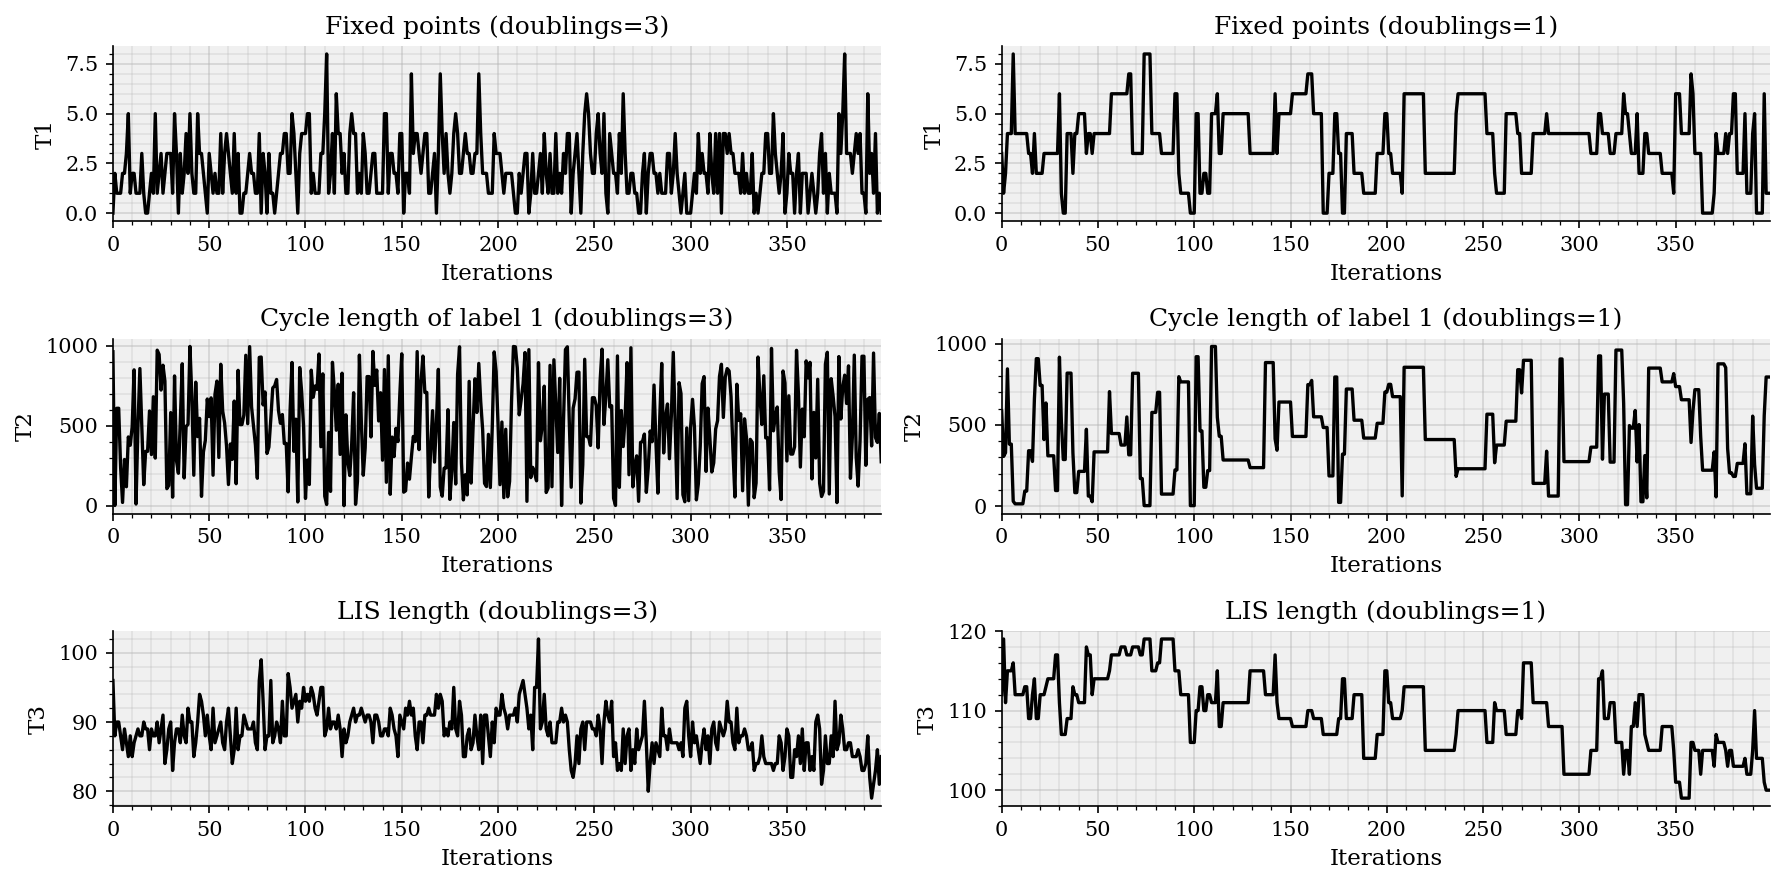

In [2]:
import numpy as np
import matplotlib.pyplot as plt

if __name__ == "__main__":
    n = 1000
    burn_in = 1000
    num_samples = 10000
    eps = 1e-3
    beta = 1.0 / n**2
    w = 15
    l = None
    seed = 0

    _apply_style()
    dist_id = DIST_NAME_TO_ID["L2"]

    diag_fns = {
        "T2_cycle_len": lambda s: cycle_length_containing_label(s, label=1),
        "T3_LIS": lis_length,
    }

    max_doublings_left = 7
    counts_L, last_state_L, diag_L = run_chain(
        n, dist_id, beta, burn_in, num_samples, eps, max_doublings_left, w, l, seed=seed, diag_fns=diag_fns
    )
    t2_L = np.asarray(diag_L["T2_cycle_len"], dtype=int)
    t3_L = np.asarray(diag_L["T3_LIS"], dtype=int)

    max_doublings_right = 1
    counts_R, last_state_R, diag_R = run_chain(
        n, dist_id, beta, burn_in, num_samples, eps, max_doublings_right, w, l, seed=seed, diag_fns=diag_fns
    )
    t2_R = np.asarray(diag_R["T2_cycle_len"], dtype=int)
    t3_R = np.asarray(diag_R["T3_LIS"], dtype=int)

    fig, axs = plt.subplots(3, 2, figsize=(12, 6), sharex=False, sharey=False)

    trace_plot(axs[0, 0], counts_L, ylabel="T1", title=r"Fixed points (doublings=3)", n_show=400)
    trace_plot(axs[0, 1], counts_R, ylabel="T1", title=r"Fixed points (doublings=1)", n_show=400)

    trace_plot(axs[1, 0], t2_L, ylabel="T2", title=r"Cycle length of label 1 (doublings=3)", n_show=400)
    trace_plot(axs[1, 1], t2_R, ylabel="T2", title=r"Cycle length of label 1 (doublings=1)", n_show=400)

    trace_plot(axs[2, 0], t3_L, ylabel="T3", title=r"LIS length (doublings=3)", n_show=400)
    trace_plot(axs[2, 1], t3_R, ylabel="T3", title=r"LIS length (doublings=1)", n_show=400)

    fig.tight_layout()
    plt.show()